MDC-LN implementation without cross-alternative interactions ($\gamma$ only)

In [ ]:
## Python basics
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from time import time
import collections
import collections.abc
collections.Iterable = collections.abc.Iterable
from sklearn.model_selection import train_test_split

# DNN & LN
import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow.keras.layers import Activation,Input, Dense, Multiply, Lambda, Add, Subtract
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model

import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('Data/generalized_simulation_data.csv')

In [3]:
data1 = np.array(data, dtype=np.float32)

z, x = np.split(data1, [2], axis=1)

In [ ]:
z_train, z_temp, \
x_train, x_temp = train_test_split(
    z, x/1000,
    test_size=0.3,
    random_state=42
)

z_val, z_test, \
x_val, x_test = train_test_split(
    z_temp, x_temp,
    test_size=0.5,
    random_state=42
)

In [ ]:
total_budget = 1000

@tf.function
def fixed_point_solver(vjp_fn, dy, tol=1e-4, max_iter=20, reg=1e-4):
    """
    Fixed point solver
    """
    def cond(i, u, _):
        return i < max_iter
    
    def body(i, u, residual_prev):
        vjp = vjp_fn(u)
        jt_u = u - vjp
        u_new = dy + jt_u
        residual = tf.reduce_mean(tf.abs(u_new - u))
        
        # Early stopping condition
        should_stop = residual < tol
        u_final = tf.cond(should_stop, lambda: u_new, lambda: u_new)
        
        return i + 1, u_final, residual
    
    _, u_final, _ = tf.while_loop(
        cond, body, 
        [0, dy, tf.constant(float('inf'), dtype=tf.float32)],
        maximum_iterations=max_iter
    )
    return u_final

@tf.function
def simplex_projection(v, T=1.0):
    """
    Simplex projection
    """
    batch_size = tf.shape(v)[0]
    n = tf.shape(v)[1]

    v_sorted, _ = tf.nn.top_k(v, k=n, sorted=True)
    v_cumsum = tf.cumsum(v_sorted, axis=1)

    indices = tf.range(1, n + 1, dtype=tf.float32)
    indices = tf.tile(tf.reshape(indices, [1, -1]), [batch_size, 1])

    T_expanded = tf.reshape(T, [-1, 1])

    rho_candidates = v_sorted - (v_cumsum - T_expanded) / indices
    mask = rho_candidates > 0

    mask_reversed = tf.reverse(mask, axis=[1])
    first_true_reversed = tf.argmax(tf.cast(mask_reversed, tf.int32), axis=1, output_type=tf.int32)
    rho = tf.cast(n - 1, tf.int32) - first_true_reversed

    has_positive = tf.reduce_any(mask, axis=1)
    rho = tf.where(has_positive, rho, tf.zeros_like(rho))

    batch_indices = tf.range(batch_size, dtype=tf.int32)
    gather_indices = tf.stack([batch_indices, rho], axis=1)
    v_cumsum_at_rho = tf.gather_nd(v_cumsum, gather_indices)

    theta = tf.where(
        has_positive,
        (v_cumsum_at_rho - T) / tf.cast(rho + 1, tf.float32),
        tf.zeros_like(T)
    )

    theta_expanded = tf.reshape(theta, [-1, 1])
    w = tf.maximum(v - theta_expanded, 0.0)
    return w

@tf.function
def random_simplex_init(batch_size, dim, seed=42):
    alpha = tf.ones([dim])
    gamma_samples = tf.random.stateless_gamma(
        seed=(seed, 0),
        shape=(batch_size, dim),
        alpha=alpha
    )
    return gamma_samples / tf.reduce_sum(gamma_samples, axis=1, keepdims=True)

@tf.function
def F_gradient_descent(x, grads, eta):
    """
    Fixed point operator F
    """
    y_candidate = x + eta * grads
    return simplex_projection(y_candidate)

@tf.function
def compute_utility_and_grad(t, socio_input, utility_model):
    """Compiled utility and gradient computation"""
    with tf.GradientTape() as tape:
        tape.watch(t)
        total_utility = utility_model([socio_input, t])
    
    grads = tape.gradient(total_utility, t)    
    grads = tf.clip_by_value(grads, -10.0, 10.0)
    return total_utility, grads

# Main optimization function - compiled once
@tf.function
def mdcev_optimization_core(psi_values, socio_input, utility_model, max_iter, eta_init, tol):
    """
    MDCEV optimization compiled as tf.function
    """
    batch_size = tf.shape(psi_values)[0]
    dim = tf.shape(psi_values)[1]

    # uniform initial budget, or one can initialize the budget proportionally to psi
    x_init = tf.ones_like(psi_values) / tf.cast(dim, tf.float32)
    
    eta_init_val = eta_init
    min_eta = 1e-5
    gamma = 0.9
    beta = 1.0
    prev_residual_init = tf.constant(float('inf'), dtype=tf.float32)

    def cond(k, x, eta, prev_residual):
        return k < max_iter

    def body(k, x, eta, prev_residual):
        # Compute gradients once
        _, grads = compute_utility_and_grad(x, socio_input, utility_model)
        
        f_x = F_gradient_descent(x, grads, eta)
        
        r_x = f_x - x
        rel_residual = tf.reduce_mean(tf.norm(r_x, axis=1))

        # Adaptive step size
        should_decrease = tf.logical_and(
            k > 0, 
            rel_residual >= prev_residual * beta
        )
        new_eta = tf.cond(
            should_decrease,
            lambda: tf.maximum(gamma * eta, min_eta),
            lambda: eta
        )
        
        return k + 1, f_x, new_eta, rel_residual

    final_k, final_x, final_eta, final_residual = tf.while_loop(
        cond, body,
        [0, x_init, eta_init_val, prev_residual_init],
        maximum_iterations=max_iter
    )

    return final_x

def mdcev_optimization(psi_values, utility_model, socio_input, 
                      x_true=None, training=True, max_iter=100, 
                      use_implicit_diff=True):
    """
    Args:
        use_implicit_diff: If True, uses implicit differentiation for efficiency.
                          If False, uses standard autodiff through the entire loop.
    """
    
    if use_implicit_diff:
        # Use implicit differentiation for efficiency
        return mdcev_with_custom_gradients(psi_values, socio_input, utility_model)
    else:
        # Use standard autodiff (less efficient but simpler)
        eta_init = tf.constant(1e-3, dtype=tf.float32)
        
        tol = tf.constant(1e-4, dtype=tf.float32)
        result = mdcev_optimization_core(
            psi_values, socio_input, utility_model, max_iter, eta_init, tol
        )
        
        return result

@tf.function
def mdcev_with_custom_gradients(psi_values, socio_input, utility_model):
    @tf.custom_gradient
    def equilibrium_solver(psi_inner):
        x_star = mdcev_optimization_core(
            psi_inner, socio_input, utility_model,
           100, 5e-3, 1e-4
        )
        def grad_fn(dy, variables=None):
            x_star_detached = tf.stop_gradient(x_star)
            
            # Compute gradients w.r.t. inputs (psi_values)
            def vjp_fn(v):
                with tf.GradientTape() as tape:
                    tape.watch(x_star_detached)
                    _, grads = compute_utility_and_grad(x_star_detached, socio_input, utility_model)
                    fx = F_gradient_descent(x_star_detached, grads, 5e-3)
                vjp_result = tape.gradient(fx, x_star_detached, output_gradients=v)
                return v - vjp_result if vjp_result is not None else v
            
            u_psi = fixed_point_solver(vjp_fn, dy)
            
            if variables is not None:
                with tf.GradientTape() as tape:
                    tape.watch(variables)
                    _, grads = compute_utility_and_grad(x_star_detached, socio_input, utility_model)
                
                # Compute VJP for variables
                var_grads = tape.gradient(grads, variables, output_gradients=dy)
                
                return u_psi, var_grads
            else:
                return u_psi
        
        return x_star, grad_fn
    
    return equilibrium_solver(psi_values)

In [ ]:
# Hyperparameters obtained via Bayesian optimization
params = {'ALT2_KP': 40, 'ALT3_KP': 10, 'ALT4_KP': 10, 'ALT2_LS': 5, 'ALT3_LS': 3, 'ALT4_LS': 5, 'ACT_ALT2': 3, 'ACT_ALT3': 5, 'ACT_ALT4': 3, 'LAYER_SIZE': 64, 'lr': 0.005}

ALT2_KP = params["ALT2_KP"]
ALT3_KP = params["ALT3_KP"]
ALT4_KP = params["ALT4_KP"]
    
ALT2_LS = params["ALT2_LS"]
ALT3_LS = params["ALT3_LS"]
ALT4_LS = params["ALT4_LS"]
    
ACT_ALT2 = params["ACT_ALT2"]
ACT_ALT3 = params["ACT_ALT3"]
ACT_ALT4 = params["ACT_ALT4"]
    
hidden_dim = params["LAYER_SIZE"]
lr = params["lr"]

# Input layers
x = Input(shape=(z_train.shape[1],), name='socio_input', dtype=tf.float32)
t = Input(shape=(x_train.shape[1],), name='time_input', dtype=tf.float32)

# psi(x) ----- socioeconomic variables
h = Dense(hidden_dim, activation='swish')(x)
h = BatchNormalization()(h)

h = Dense(hidden_dim, activation='swish')(h)
h = BatchNormalization()(h)

h = Dense(x_train.shape[1], activation='swish', name='psi_swish')(h)
h = Dense(x_train.shape[1])(h)
psi = Activation('softplus', name='psi')(h)

psi_model = Model(inputs=x, outputs=psi)

t_OUT = Lambda(lambda x: tf.reshape(x[:, 0], [-1, 1]))(t)
t_ALT2 = Lambda(lambda x: tf.reshape(x[:, 1], [-1, 1]))(t)
t_ALT3 = Lambda(lambda x: tf.reshape(x[:, 2], [-1, 1]))(t)
t_ALT4 = Lambda(lambda x: tf.reshape(x[:, 3], [-1, 1]))(t)

# gamma(t) ----- satiation
lattice_inputs_ALT2 = []
lattice_inputs_ALT3 = []
lattice_inputs_ALT4 = []
    
ALT2_calib_layer = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(
    0., 1., num=ALT2_KP),
    dtype=tf.float32,
    output_min=0.0,
    output_max=ALT2_LS - 1.0,
    kernel_regularizer=[("wrinkle", 0.0, 0.5),('hessian', 0.0, 1e-4)],
    monotonicity='increasing',
    convexity='concave',
    kernel_initializer='zeros',
    name='t_ALT2_Calib',
)

ALT3_calib_layer = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(
    0., 1., num=ALT3_KP),
    dtype=tf.float32,
    output_min=0.0,
    output_max=ALT3_LS - 1.0,
    kernel_regularizer=[("wrinkle", 0.0, 0.5),('hessian', 0.0, 1e-4)],
    monotonicity='increasing',
    convexity='concave',
    kernel_initializer='zeros',
    name='t_ALT3_Calib',
)

ALT4_calib_layer = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(
    0., 1., num=ALT4_KP),
    dtype=tf.float32,
    output_min=0.0,
    output_max=ALT4_LS - 1.0,
    kernel_regularizer=[("wrinkle", 0.0, 0.5),('hessian', 0.0, 1e-4)],
    monotonicity='increasing',
    convexity='concave',
    kernel_initializer='zeros',
    name='t_ALT4_Calib',
)

ALT2_T_calibrator = ALT2_calib_layer(t_ALT2)
ALT3_T_calibrator = ALT3_calib_layer(t_ALT3)
ALT4_T_calibrator = ALT4_calib_layer(t_ALT4)
    
lattice_inputs_ALT2.append(ALT2_T_calibrator)
lattice_inputs_ALT3.append(ALT3_T_calibrator)
lattice_inputs_ALT4.append(ALT4_T_calibrator)

ALT2_lattice_layer = tfl.layers.Lattice(   
    lattice_sizes=[ALT2_LS],
    monotonicities=[1],
    output_min=0,
    output_max=1,
    # output_min=-100,
    # output_max=100,
    name='lattice_ALT2',
)

ALT3_lattice_layer = tfl.layers.Lattice(   
    lattice_sizes=[ALT3_LS],
    monotonicities=[1],
    output_min=0,
    output_max=1,
    # output_min=-100,
    # output_max=100,
    name='lattice_ALT3',
)

ALT4_lattice_layer = tfl.layers.Lattice(   
    lattice_sizes=[ALT4_LS],
    monotonicities=[1],
    output_min=0,
    output_max=1,
    # output_min=-100,
    # output_max=100,
    name='lattice_ALT4',
)

ALT2_output_layer = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0.0, 1.0, ACT_ALT2),
    output_min=0,
    output_max=1,
    monotonicity='increasing', 
    convexity='concave',
    name='ACT_ALT2'
)

ALT3_output_layer = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0.0, 1.0, ACT_ALT3),
    output_min=0,
    output_max=1,
    monotonicity='increasing', 
    convexity='concave',
    name='ACT_ALT3'
)

ALT4_output_layer = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0.0, 1.0, ACT_ALT4),
    output_min=0,
    output_max=1,
    monotonicity='increasing', 
    convexity='concave',
    name='ACT_ALT4'
)

# difference in difference formula to ensure vanishing at zero
zero_input_ALT2 = tf.zeros_like(t_ALT2)
zero_input_ALT3 = tf.zeros_like(t_ALT3) 
zero_input_ALT4 = tf.zeros_like(t_ALT4)
    
zero_calib_ALT2 = ALT2_calib_layer(zero_input_ALT2)
zero_calib_ALT3 = ALT3_calib_layer(zero_input_ALT3)
zero_calib_ALT4 = ALT4_calib_layer(zero_input_ALT4)

zero_lattice_ALT2 = ALT2_lattice_layer([zero_calib_ALT2])
zero_lattice_ALT3 = ALT3_lattice_layer([zero_calib_ALT3])
zero_lattice_ALT4 = ALT4_lattice_layer([zero_calib_ALT4])

zero_output_ALT2 = ALT2_output_layer(zero_lattice_ALT2)
zero_output_ALT3 = ALT3_output_layer(zero_lattice_ALT3)
zero_output_ALT4 = ALT4_output_layer(zero_lattice_ALT4)

gamma_ALT2_lattice = ALT2_lattice_layer(lattice_inputs_ALT2)
gamma_ALT2_raw = ALT2_output_layer(gamma_ALT2_lattice)
gamma_ALT2 = Subtract(name='gamma_ALT2')([gamma_ALT2_raw, zero_output_ALT2])

gamma_ALT3_lattice = ALT3_lattice_layer(lattice_inputs_ALT3)
gamma_ALT3_raw = ALT3_output_layer(gamma_ALT3_lattice)
gamma_ALT3 = Subtract(name='gamma_ALT3')([gamma_ALT3_raw, zero_output_ALT3])

gamma_ALT4_lattice = ALT4_lattice_layer(lattice_inputs_ALT4)
gamma_ALT4_raw = ALT4_output_layer(gamma_ALT4_lattice)
gamma_ALT4 = Subtract(name='gamma_ALT4')([gamma_ALT4_raw, zero_output_ALT4])

utility_OUT = Multiply(name='utility_OUT')([psi[:, 0], t_OUT])
utility_ALT2 = Multiply(name='utility_ALT2')([psi[:, 1], gamma_ALT2])
utility_ALT3 = Multiply(name='utility_ALT3')([psi[:, 2], gamma_ALT3])
utility_ALT4 = Multiply(name='utility_ALT4')([psi[:, 3], gamma_ALT4])
    
utility = Add(name='utility')([utility_OUT, utility_ALT2, utility_ALT3, utility_ALT4])

utility_model = Model(inputs=[x, t], outputs=utility)

In [ ]:
T = 1.0
batch_size = tf.shape(psi)[0]
num_alts = tf.shape(psi)[1]

tf.debugging.set_log_device_placement(True)
tf.config.run_functions_eagerly(False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# training loop
def train_model(epochs, batch_size):
    best_val_loss = float('inf')
    wait = 0
    patience = 5

    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    train_summary_writer = tf.summary.create_file_writer(log_dir + '/train')
    val_summary_writer = tf.summary.create_file_writer(log_dir + '/validation')
        
    history = {'loss': [], 'val_loss': []}
    for epoch in range(epochs):
        indices = np.random.permutation(len(z_train))
        epoch_loss = 0

        epoch_pbar = tqdm(range(0, len(indices), batch_size), 
                        desc=f'Epoch {epoch+1}/{epochs}',
                        leave=False)
            
        batch_count = 0
        start_time = time()
            
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_socio = z_train[batch_indices]
            batch_time = x_train[batch_indices]
                
            with tf.GradientTape() as tape:
                batch_psi = psi_model(batch_socio, training=True)
                predicted_time = mdcev_optimization(
                    batch_psi,
                    utility_model,
                    batch_socio,
                    x_true=batch_time,
                    training=True
                )
                loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(batch_time, predicted_time))
                variables = (psi_model.trainable_variables + 
                           utility_model.trainable_variables)

                gradients = tape.gradient(loss, variables)
                optimizer.apply_gradients(zip(gradients, variables))
                    
            epoch_loss += loss.numpy() * len(batch_indices)
            batch_count += 1
                    
            elapsed_time = time() - start_time
            avg_time_per_batch = elapsed_time / batch_count if batch_count > 0 else 0
                    
            epoch_pbar.set_postfix({
                'loss': f'{loss.numpy():.4f}',
                'avg_loss': f'{epoch_loss/(batch_count*batch_size):.4f}',
                'batch_time': f'{avg_time_per_batch:.2f}s'
            })
            epoch_pbar.update(1)
            
        epoch_pbar.close()

        epoch_loss /= len(z_train)
            
        val_psi = psi_model(z_val)
        val_pred = mdcev_optimization(
            val_psi,
            utility_model,
            z_val,
            x_true=None,
            training=False
        )
        val_loss = tf.reduce_mean(tf.square(val_pred - x_val))

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', epoch_loss, step=epoch)
            
        with val_summary_writer.as_default():
            tf.summary.scalar('loss', val_loss, step=epoch)
            
        history['loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)

        if val_loss == np.nan:
            break

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = utility_model.get_weights()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
            
        print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")

    utility_model.set_weights(best_model)

    return history

history = train_model(epochs=100, batch_size=256)

Epoch 1/100 - loss: 0.1073 - val_loss: 0.0649


Epoch 2/100 - loss: 0.0613 - val_loss: 0.0585


Epoch 3/100 - loss: 0.0518 - val_loss: 0.0482


Epoch 4/100 - loss: 0.0485 - val_loss: 0.0463


Epoch 5/100 - loss: 0.0481 - val_loss: 0.0469


Epoch 6/100 - loss: 0.0477 - val_loss: 0.0477


Epoch 7/100 - loss: 0.0480 - val_loss: 0.0473


Epoch 8/100 - loss: 0.0489 - val_loss: 0.0477


Early stopping triggered at epoch 9


In [8]:
test_psi = psi_model.predict(z_test)
y_pred_test = mdcev_optimization(
    test_psi, utility_model, z_test
)

def calculate_metrics(y_true, y_pred):
    metrics_per_class = []
    
    for i in range(y_true.shape[1]):
        true_class = y_true[:, i]
        pred_class = y_pred[:, i]
        
        # MSE
        mse = np.mean(np.square(true_class - pred_class))
        
        # RMSE
        rmse = np.sqrt(mse) * total_budget

        metrics_per_class.append({
            'RMSE': rmse
        })
    
    return metrics_per_class

test_metrics = calculate_metrics(x_test, y_pred_test)

# Print results
alternatives = ['Outside', 'ALT2', 'ALT3', 'ALT4']
print("\nLattice NN Test Set Metrics:")
print("-" * 50)

for i, alt in enumerate(alternatives):
    metric = test_metrics[i]
    print(f"\n{alt}:")
    print(f"RMSE: {metric['RMSE']:.4f}")

47/47 [==============================] - 0s 1ms/step

Lattice NN Test Set Metrics:
--------------------------------------------------

Outside:
RMSE: 274.1169

ALT2:
RMSE: 74.8474

ALT3:
RMSE: 164.1698

ALT4:
RMSE: 265.8043


In [9]:
# Extracting layers for utility shape plotting
def get_gamma(z_batch, time_points):
    n_samples = z_batch.shape[0]
    n_times = len(time_points)

    psi_input = np.repeat(z_batch, n_times, axis=0)
    psi = psi_model.predict(psi_input, verbose=0)
    psi = psi.reshape(n_samples, n_times, -1)

    t_inputs = []
    for j in range(n_samples):
        for tp in time_points:
            t_input = np.zeros(x_train.shape[1])
            t_input[1:] = tp
            t_inputs.append(t_input)
    t_inputs = np.array(t_inputs)

    gamma_outputs = tf.keras.Model(
        inputs=utility_model.inputs,
        outputs=[
            utility_model.get_layer('utility_ALT2').input[1],
            utility_model.get_layer('utility_ALT3').input[1],
            utility_model.get_layer('utility_ALT4').input[1]
        ]
    )
    gammas = gamma_outputs.predict([psi_input, t_inputs], verbose=0)

    gammas = [g.reshape(n_samples, n_times) for g in gammas]

    return gammas + [psi]

intermediate_layer_model = tf.keras.Model(
    inputs=utility_model.inputs,
    outputs=[
        utility_model.get_layer('utility_ALT2').input[1],
        utility_model.get_layer('utility_ALT3').input[1],
        utility_model.get_layer('utility_ALT4').input[1]
    ]
)

z_samples = z_test

In [10]:
time_points = np.linspace(0, 1, 100)

budget_points = time_points * total_budget

utility_values = get_gamma(z_samples, time_points)
g_ALT2, g_ALT3, g_ALT4, psi = utility_values

Plotting $\gamma$ functions (Satiation)

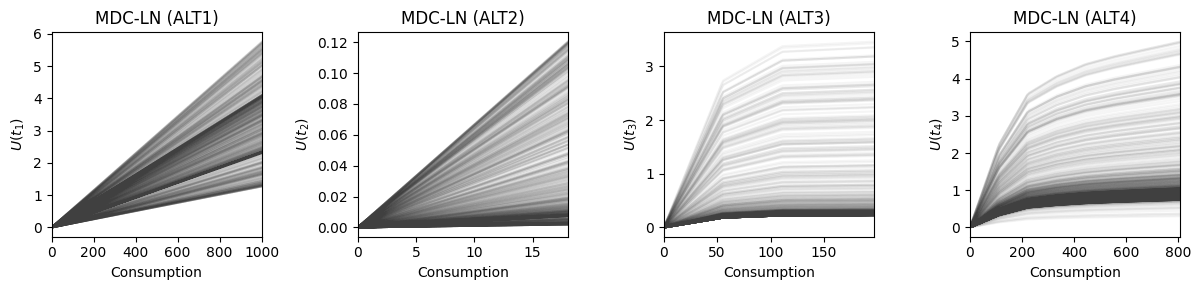

In [11]:
# 90th percentile for each alternative
p90_1 = np.percentile(x_train[:, 0] * total_budget, 90)
p90_2 = np.percentile(x_train[:, 1] * total_budget, 90)
p90_3 = np.percentile(x_train[:, 2] * total_budget, 90)
p90_4 = np.percentile(x_train[:, 3] * total_budget, 90)

time_points_1 = np.linspace(0, p90_1 / total_budget, 100)
time_points_2 = np.linspace(0, p90_2 / total_budget, 100)
time_points_3 = np.linspace(0, p90_3 / total_budget, 100)
time_points_4 = np.linspace(0, p90_4 / total_budget, 100)

budget_points_1 = time_points_1 * total_budget
budget_points_2 = time_points_2 * total_budget
budget_points_3 = time_points_3 * total_budget
budget_points_4 = time_points_4 * total_budget

total_samples = len(z_samples)

n_samples = min(1000, total_samples)
random_indices = np.random.choice(total_samples, size=n_samples, replace=False)

# compute utility for each alternative
def compute_utilities_for_alt(alt_idx, time_points_alt, z_samples, random_indices):
    utility_values = get_gamma(z_samples[random_indices], time_points_alt)
    
    if alt_idx == 0:
        g_alt = time_points_alt
        psi_idx = 0
    elif alt_idx == 1:  # ALT2
        g_alt = utility_values[0]
        psi_idx = 1
    elif alt_idx == 2:  # ALT3
        g_alt = utility_values[1]
        psi_idx = 2
    else:  # ALT4
        g_alt = utility_values[2]
        psi_idx = 3
    
    psi = utility_values[3]
    
    dnn_all = []
    psi_all = []
    
    for idx, i in enumerate(random_indices):
        if alt_idx == 0:
            dnn_all.append(psi[idx, :, psi_idx] * g_alt)
        else:
            dnn_all.append(psi[idx, :, psi_idx] * g_alt[idx, :])
        psi_all.append(np.mean(psi[idx, :, psi_idx]))
    
    return np.array(dnn_all), np.array(psi_all)

dnn1_all, psi1_all = compute_utilities_for_alt(0, time_points_1, z_samples, random_indices)
dnn2_all, psi2_all = compute_utilities_for_alt(1, time_points_2, z_samples, random_indices)
dnn3_all, psi3_all = compute_utilities_for_alt(2, time_points_3, z_samples, random_indices)
dnn4_all, psi4_all = compute_utilities_for_alt(3, time_points_4, z_samples, random_indices)

# Remove the top 5% based on psi values
def filter_by_psi(psi_values, utility_values):
    threshold = np.percentile(psi_values, 95)
    valid_indices = psi_values <= threshold
    return utility_values[valid_indices], valid_indices

dnn1_filtered, _ = filter_by_psi(psi1_all, dnn1_all)
dnn2_filtered, _ = filter_by_psi(psi2_all, dnn2_all)
dnn3_filtered, _ = filter_by_psi(psi3_all, dnn3_all)
dnn4_filtered, _ = filter_by_psi(psi4_all, dnn4_all)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# ALT1
for i in range(dnn1_filtered.shape[0]):
    axes[0].plot(budget_points_1, dnn1_filtered[i], color="#404040", alpha=0.05)
axes[0].set_title('MDC-LN (ALT1)')
axes[0].set_xlabel('Consumption')
axes[0].set_ylabel(r'$U(t_1)$')
axes[0].set_xlim(0, p90_1)

# ALT2
for i in range(dnn2_filtered.shape[0]):
    axes[1].plot(budget_points_2, dnn2_filtered[i], color="#404040", alpha=0.05)
axes[1].set_title('MDC-LN (ALT2)')
axes[1].set_xlabel('Consumption')
axes[1].set_ylabel(r'$U(t_2)$')
axes[1].set_xlim(0, p90_2)

# ALT3
for i in range(dnn3_filtered.shape[0]):
    axes[2].plot(budget_points_3, dnn3_filtered[i], color="#404040", alpha=0.05)
axes[2].set_title('MDC-LN (ALT3)')
axes[2].set_xlabel('Consumption')
axes[2].set_ylabel(r'$U(t_3)$')
axes[2].set_xlim(0, p90_3)

# ALT4
for i in range(dnn4_filtered.shape[0]):
    axes[3].plot(budget_points_4, dnn4_filtered[i], color="#404040", alpha=0.05)
axes[3].set_title('MDC-LN (ALT4)')
axes[3].set_xlabel('Consumption')
axes[3].set_ylabel(r'$U(t_4)$')
axes[3].set_xlim(0, p90_4)

plt.tight_layout()
plt.show()